<a href="https://colab.research.google.com/github/Sumudu01/CardioCare/blob/data-Visualization/dataVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload your CSV (e.g., heartAttack_cleaned1.csv)...


Saving heartAttack_cleaned1.csv to heartAttack_cleaned1 (1).csv
 Loaded: heartAttack_cleaned1 (1).csv  |  Shape: (151768, 22)

🔎 Detected columns:
  age               → age
  cholesterol       → ['cholesterol_level']
  bp                → None
  systolic_bp       → None
  diastolic_bp      → None
  smoking_status    → smoking_status_Never
  alcohol_consumption → None
  physical_activity → physical_activity_Low
  heart_attack      → heart_attack

📊 Plotting distributions...


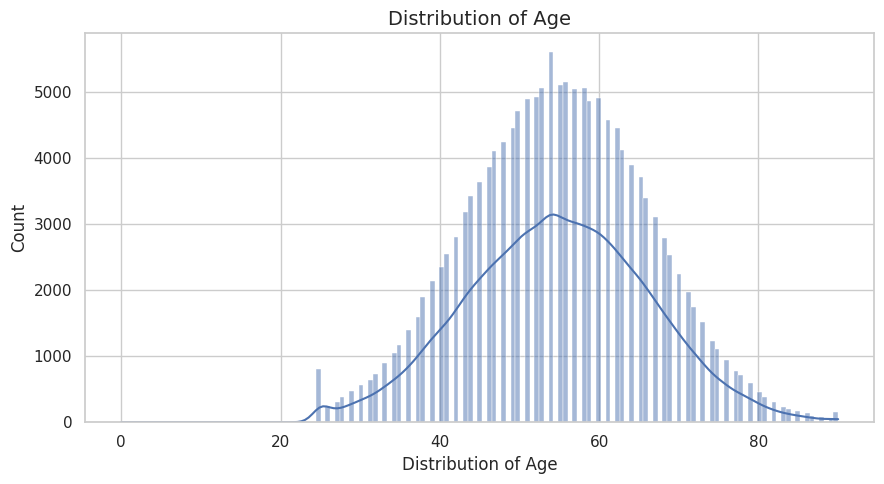

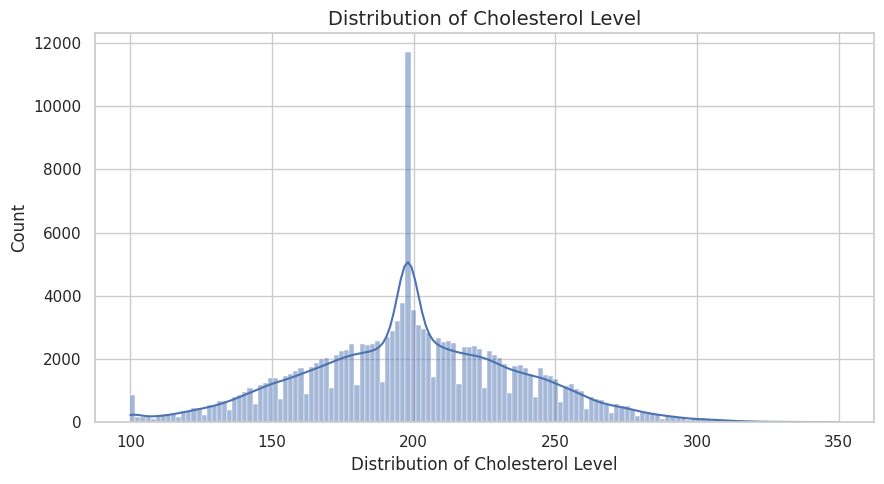


🧬 Lifestyle vs Heart Attack (rate by category)...


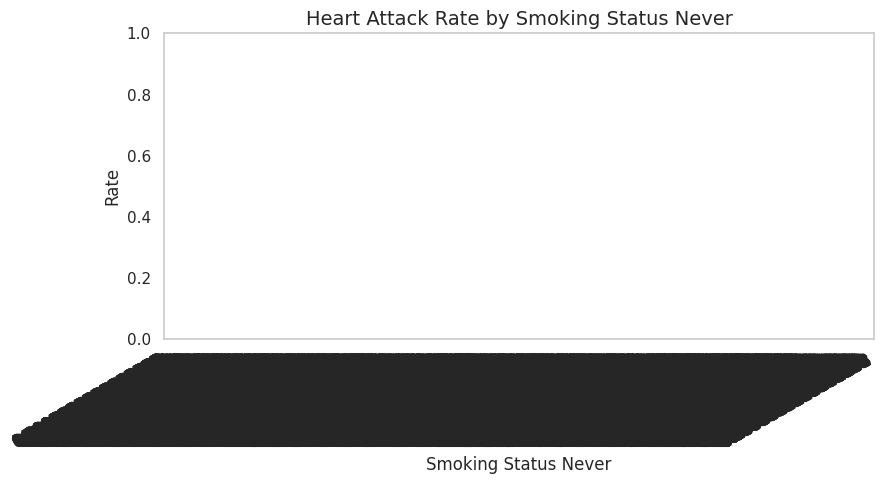

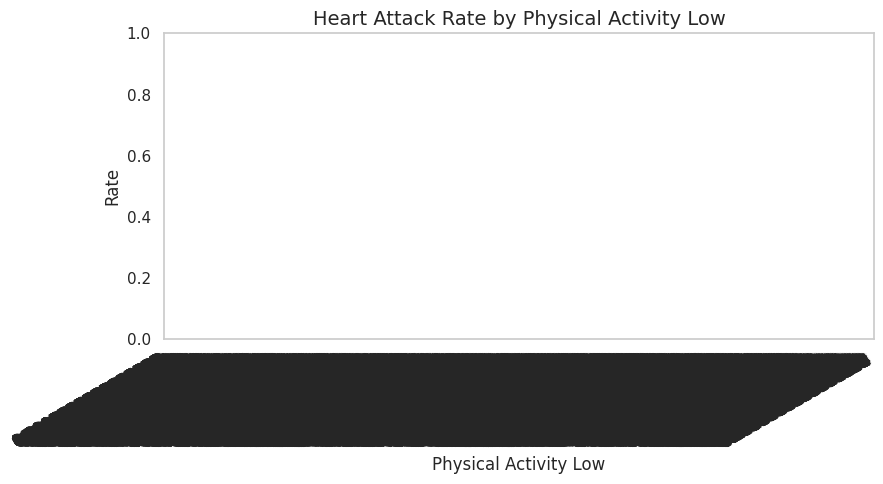


🔗 Correlation heatmap (numerical features)...


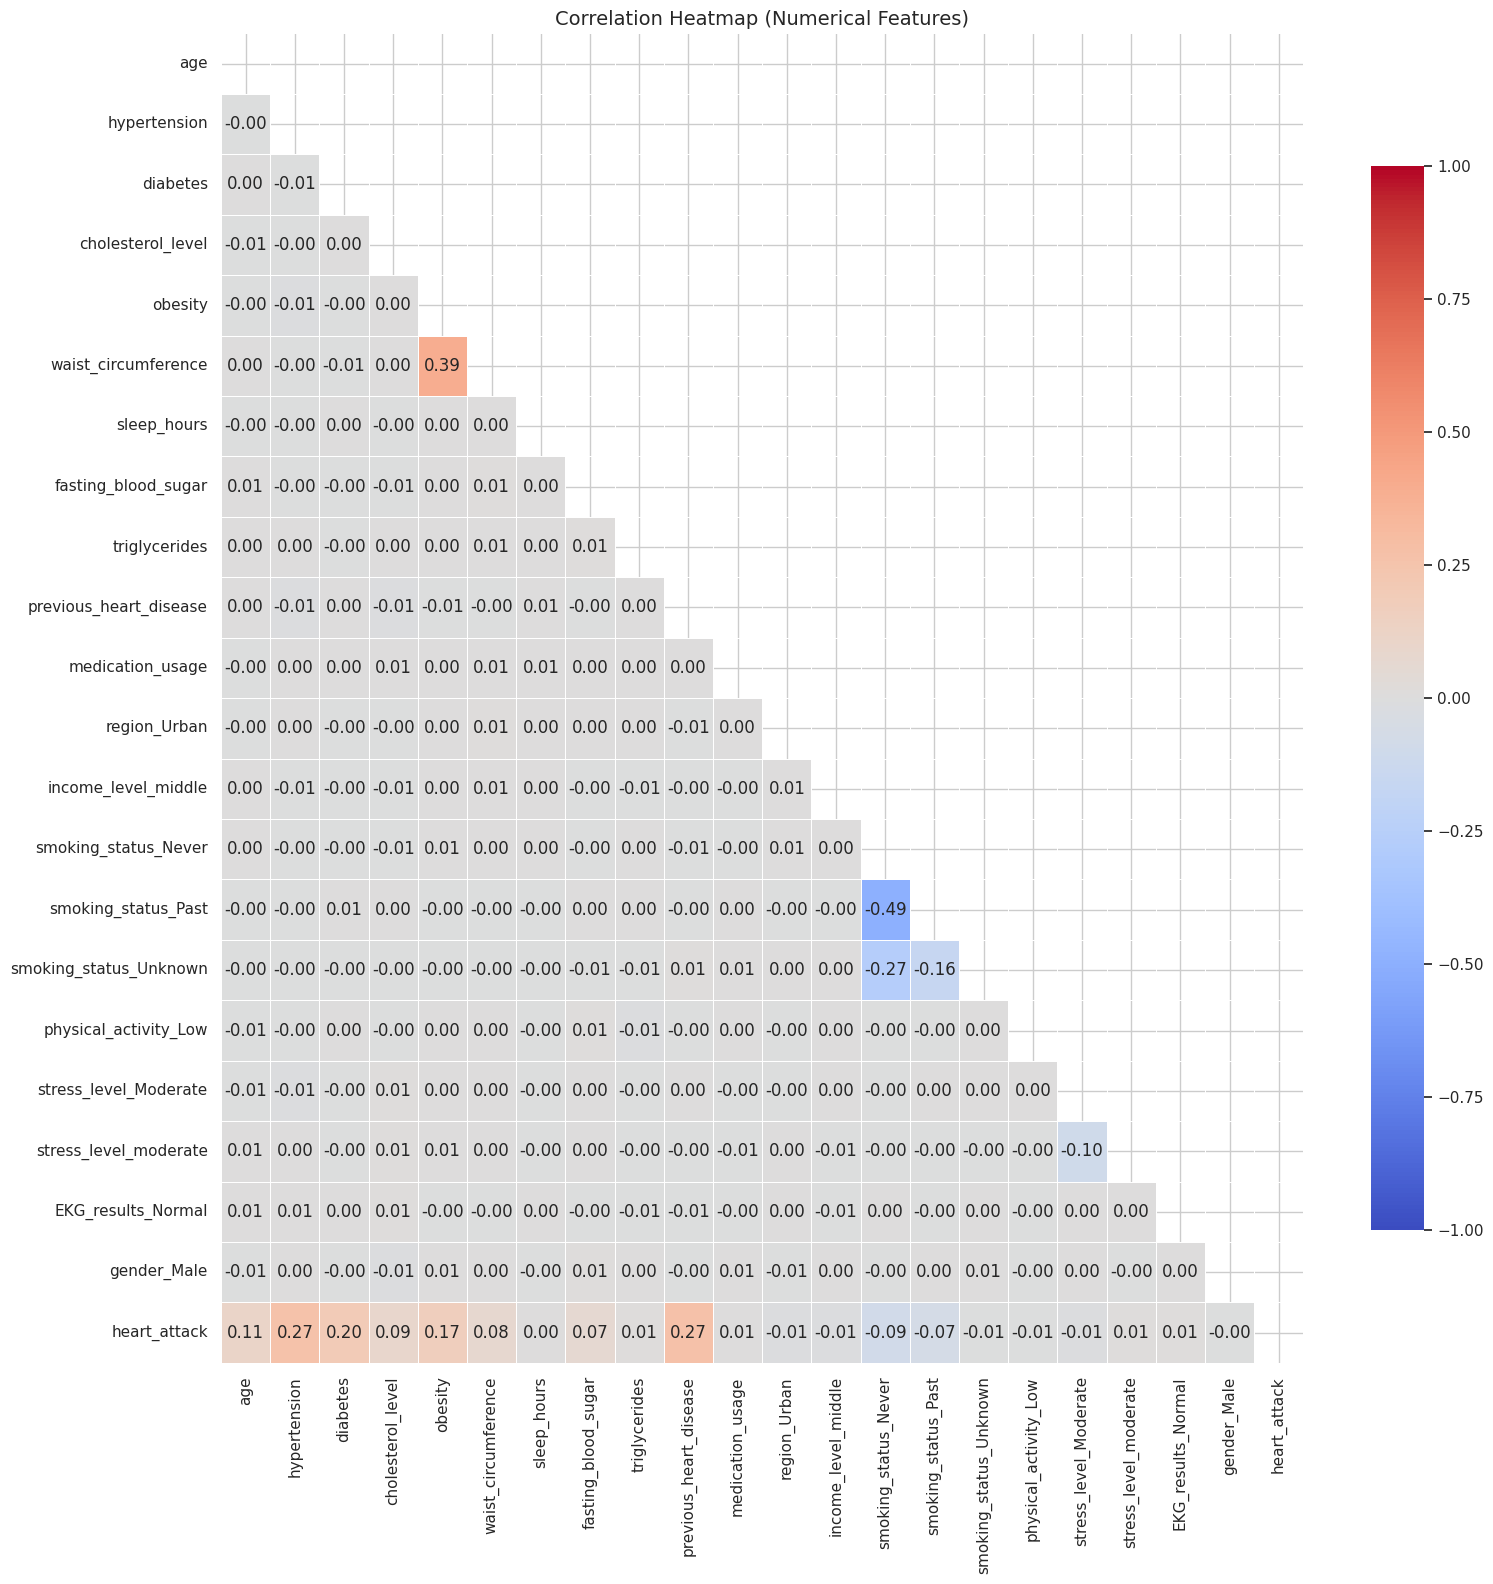


✅ Done. If a plot you expected didn't show up, check the printed 'Detected columns' and rename your columns to the suggested forms (e.g., 'age', 'cholesterol', 'bp', 'smoking_status', 'alcohol_consumption', 'physical_activity', 'heart_attack').


In [ ]:
# ---- Imports & setup
import os, io, re, math, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pretty plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"]  = 12

df = None
try:

    from google.colab import files
    print("Please upload your CSV (e.g., heartAttack_cleaned.csv)...")
    uploaded = files.upload()
    csv_candidates = [name for name in uploaded.keys() if name.lower().endswith(".csv")]
    assert len(csv_candidates) > 0, "No CSV file uploaded."
    path = csv_candidates[0]
    df = pd.read_csv(io.BytesIO(uploaded[path]))
    print(f" Loaded: {path}  |  Shape: {df.shape}")
except Exception as e:
    raise RuntimeError(f"Failed to load CSV: {e}")

# Remove accidental index columns
for c in list(df.columns):
    if re.fullmatch(r"unnamed:\s*0", str(c).strip(), flags=re.I):
        df = df.drop(columns=[c])

def find_col(candidates):
    """
    Return the first matching column name from df, trying:
      - exact lowercase match (spaces -> underscores)
      - substring match
    """
    cols_norm = {c: re.sub(r"\s+", "_", str(c).strip().lower()) for c in df.columns}
    # exact matches first
    for c, cn in cols_norm.items():
        if cn in candidates:
            return c
    # then substring matches
    for c, cn in cols_norm.items():
        if any(cand in cn for cand in candidates):
            return c
    return None

age_col = find_col({"age"})
chol_cols = [
    find_col({"cholesterol", "cholestrol", "chol", "cholesterol_mg_dl"})
]
# If more than one cholesterol-like column exists, extend the list
chol_cols = [c for c in chol_cols if c is not None]

# Blood pressure: can be one 'bp' or split into systolic/diastolic
bp_col        = find_col({"bp", "blood_pressure", "resting_bp"})
sys_bp_col    = find_col({"systolic_bp", "sbp"})
dia_bp_col    = find_col({"diastolic_bp", "dbp"})

# Lifestyle
smoke_col     = find_col({"smoking_status", "smoker", "smoking", "smoke"})
alcohol_col   = find_col({"alcohol_consumption", "alcohol_use", "alcohol", "alcohol_intake"})
activity_col  = find_col({"physical_activity", "exercise", "activity_level", "physical_activity_level"})

# Target
target_col = find_col({"heart_attack", "heartattack", "has_heart_attack", "target", "label",
                       "outcome", "disease", "heart_disease", "class"})

print("\n🔎 Detected columns:")
print(f"  age               → {age_col}")
print(f"  cholesterol       → {chol_cols}")
print(f"  bp                → {bp_col}")
print(f"  systolic_bp       → {sys_bp_col}")
print(f"  diastolic_bp      → {dia_bp_col}")
print(f"  smoking_status    → {smoke_col}")
print(f"  alcohol_consumption → {alcohol_col}")
print(f"  physical_activity → {activity_col}")
print(f"  heart_attack      → {target_col}")

# ---- 3) Light cleaning for visuals (non-destructive)
df_vis = df.copy()

# Convert target to 0/1 if needed
if target_col is not None:
    if not np.issubdtype(df_vis[target_col].dtype, np.number):
        mapping = {
            "yes":1, "y":1, "true":1, "present":1, "positive":1, "pos":1, "1":1,
            "no":0,  "n":0, "false":0, "absent":0, "negative":0, "neg":0, "0":0
        }
        df_vis[target_col] = df_vis[target_col].astype(str).str.strip().str.lower().map(mapping)
    # final cast if possible
    try:
        df_vis[target_col] = df_vis[target_col].astype("Int64")
    except Exception:
        pass

# Fix obviously invalid cholesterol (e.g., negatives)
for c in chol_cols:
    if c is not None and np.issubdtype(df_vis[c].dtype, np.number):
        n_neg = (df_vis[c] < 0).sum()
        if n_neg > 0:
            print(f"⚠️ Found {n_neg} negative values in '{c}'. Treating them as NaN for plots.")
            df_vis.loc[df_vis[c] < 0, c] = np.nan

# ---- Helpers
def nice_title(s):
    return s.replace("_"," ").title()

def show_hist(series, title, bins="auto"):
    ax = sns.histplot(series.dropna(), kde=True, bins=bins)
    ax.set_title(title)
    ax.set_xlabel(title)
    plt.tight_layout()
    plt.show()

def plot_rate_by_category(cat_col, tgt_col, data):
    if cat_col is None or tgt_col is None:
        return False
    # only if target looks binary (0/1)
    valid = set(pd.Series(data[tgt_col].dropna().unique()).astype(str))
    if not valid.issubset({"0", "1", "<NA>"}):
        print(f"ℹ️ Skipping rate plot for '{cat_col}' since '{tgt_col}' is not binary 0/1.")
        return False
    tmp = (data[[cat_col, tgt_col]]
           .dropna()
           .groupby(cat_col, dropna=False)[tgt_col]
           .mean()
           .reset_index(name="heart_attack_rate"))
    # Sort by rate descending
    tmp = tmp.sort_values("heart_attack_rate", ascending=False)
    ax = sns.barplot(data=tmp, x=cat_col, y="heart_attack_rate")
    ax.set_title(f"Heart Attack Rate by {nice_title(cat_col)}")
    ax.set_xlabel(nice_title(cat_col))
    ax.set_ylabel("Rate")
    ax.set_ylim(0, 1)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()
    return True

# ---- 4) Distributions
print("\nPlotting distributions...")
if age_col is not None and np.issubdtype(df_vis[age_col].dtype, np.number):
    show_hist(df_vis[age_col], f"Distribution of {nice_title(age_col)}")

if chol_cols:
    for c in chol_cols:
        if c is not None and np.issubdtype(df_vis[c].dtype, np.number):
            show_hist(df_vis[c], f"Distribution of {nice_title(c)}")

# BP: one combined or split into systolic/diastolic
if bp_col is not None and np.issubdtype(df_vis[bp_col].dtype, np.number):
    show_hist(df_vis[bp_col], f"Distribution of {nice_title(bp_col)}")
else:
    if sys_bp_col is not None and np.issubdtype(df_vis[sys_bp_col].dtype, np.number):
        show_hist(df_vis[sys_bp_col], f"Distribution of {nice_title(sys_bp_col)}")
    if dia_bp_col is not None and np.issubdtype(df_vis[dia_bp_col].dtype, np.number):
        show_hist(df_vis[dia_bp_col], f"Distribution of {nice_title(dia_bp_col)}")

# ---- 5) Lifestyle vs Heart Attack (rate plots)
print("\n🧬 Lifestyle vs Heart Attack (rate by category)...")
_ = plot_rate_by_category(smoke_col,   target_col, df_vis)
_ = plot_rate_by_category(alcohol_col, target_col, df_vis)
_ = plot_rate_by_category(activity_col, target_col, df_vis)

# ---- 6) Correlation heatmap (numerical features)
print("\n🔗 Correlation heatmap (numerical features)...")
num_cols = df_vis.select_dtypes(include=[np.number]).columns
if len(num_cols) >= 2:
    corr = df_vis[num_cols].corr(method="pearson")
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(min(1.1*len(num_cols), 16), min(1.1*len(num_cols), 16)))
    ax = sns.heatmap(
        corr, mask=mask, annot=True, fmt=".2f",
        cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )
    ax.set_title("Correlation Heatmap (Numerical Features)")
    plt.tight_layout()
    plt.show()
else:
    print("ℹNot enough numerical columns for a heatmap.")

print("\nDone. If a plot you expected didn't show up, check the printed 'Detected columns' and rename your columns to the suggested forms (e.g., 'age', 'cholesterol', 'bp', 'smoking_status', 'alcohol_consumption', 'physical_activity', 'heart_attack').")
